<a href="https://colab.research.google.com/github/stwater20/AIS3-2024-Material/blob/main/AIS3_Lab6_Malware_API_Sequence_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls -al

total 7304
drwxr-xr-x   5 shengshan  staff      160 Nov 21 13:03 .
drwxr-xr-x  11 shengshan  staff      352 Nov 21 11:34 ..
-rw-r--r--   1 shengshan  staff   204826 Nov 21 13:03 Malware_API_Sequence_Using_LSTM.ipynb
-rw-r--r--   1 shengshan  staff      211 Nov 21 13:03 README.md
-rw-r--r--   1 shengshan  staff  3525445 Nov 21 13:02 data_demo.zip


In [2]:
!unzip data_demo.zip

Archive:  data_demo.zip
  inflating: data_demo.npz           


In [3]:
import numpy as np

# 讀取 npz 檔案
data = np.load('data_demo.npz')

# 列出檔案中所有的陣列
print(list(data.keys()))

['x_name', 'x_semantic', 'y']


In [4]:
data['x_name']

array([[  1,   4,  59, ...,   0,   0,   0],
       [ 10,  11,  10, ...,   0,   0,   0],
       [  1,   4,  59, ...,   0,   0,   0],
       ...,
       [123, 253, 253, ...,   0,   0,   0],
       [ 15,   3,   3, ...,  27,  27,  27],
       [  1,  10,  11, ...,   9,  76,  52]])

In [5]:
len(data['x_name'][0]) # 每個軟體有 1000 個 API 序列

1000

In [6]:
data['x_semantic']

array([[  4, 101,  21, ...,  14,  14,  14],
       [  0,  25, 255, ...,  14,  14,  14],
       [  4, 101,  21, ...,  14,  14,  14],
       ...,
       [  0,   1, 163, ...,  14,  14,  14],
       [  0,   5,  61, ...,  14,  32,  33],
       [  4, 101,  21, ...,   5,  79,  80]])

In [7]:
len(data['x_semantic'][0])

4000

In [8]:
data['y'],len(data['y'])

(array([[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]]),
 4000)

In [9]:
flat_list = [item for sublist in data['y'].tolist() for item in sublist]

In [10]:
from collections import Counter
Counter(flat_list)

Counter({0: 2000, 1: 2000})

In [11]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Embedding, LSTM, Linear, BCELoss
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import warnings

# 忽略警告
warnings.filterwarnings("ignore")

# 定義 LSTM 神經網路模型
class LSTMNet(torch.nn.Module):
    def __init__(self):
        super(LSTMNet, self).__init__()
        # 定義嵌入層，輸入為316，嵌入向量維度為16
        self.embedder = Embedding(num_embeddings=316, embedding_dim=16)
        # 定義雙向LSTM層，輸入維度為16，隱藏層維度為100，設置 batch_first=True
        self.lstm = LSTM(input_size=16, hidden_size=100, bidirectional=True, batch_first=True)
        # 定義全連接層1，輸入維度為200，輸出維度為64
        self.lin1 = Linear(200, 64)
        # 定義全連接層2，輸入維度為64，輸出維度為1
        self.lin2 = Linear(64, 1)

    # 定義前向傳播
    def forward(self, x):
        # 通過嵌入層
        x = self.embedder(x)
        # 通過LSTM層，並獲取最後一層的隱藏狀態
        x, (h_n, c_n) = self.lstm(x)
        # 拼接雙向LSTM的最後一層隱藏狀態
        x = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        # 通過全連接層1，並應用ReLU激活函數
        x = F.relu(self.lin1(x))
        # 通過全連接層2，並應用Sigmoid激活函數
        x = torch.sigmoid(self.lin2(x))
        return x

# 測試模型
def test(model, device, test_loader):
    model.eval()  # 設置模型為評估模式
    all_preds = []  # 用來存儲所有預測結果
    all_targets = []  # 用來存儲所有真實標籤
    with torch.no_grad():  # 在不需要梯度計算的上下文中
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # 獲取模型的輸出
            preds = output.round()  # 將輸出四捨五入為0或1
            all_preds.extend(preds.view(-1).cpu().numpy())  # 將預測結果添加到列表中
            all_targets.extend(target.cpu().numpy())  # 將真實標籤添加到列表中

    # 計算指標
    precision = precision_score(all_targets, all_preds)  # 計算精確度
    recall = recall_score(all_targets, all_preds)  # 計算召回率
    f1 = f1_score(all_targets, all_preds)  # 計算F1分數

    return precision, recall, f1  # 返回精確度、召回率和F1分數


In [12]:
data = np.load('./data_demo.npz')
train_x_name = data['x_name']
train_y = data['y']
test_x_name = data['x_name']
test_y = data['y']

In [13]:
# 特殊用途，第一次不要執行，看到後面就知道了XD
# train_x_name = train_x
# train_y = train_y
# test_x_name = test_x
# test_y = test_y

In [14]:
# 將 NumPy 陣列轉換為 PyTorch 張量並設置類型為長整數（long），適用於分類任務中的索引
train_xt = torch.from_numpy(train_x_name).long()
test_xt = torch.from_numpy(test_x_name).long()
train_yt = torch.from_numpy(train_y.astype(np.float32))
test_yt = torch.from_numpy(test_y.astype(np.float32))

In [15]:
# 創建 TensorDataset，用於將輸入和標籤配對
train_data = TensorDataset(train_xt, train_yt)
test_data = TensorDataset(test_xt, test_yt)

In [16]:
train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True, num_workers=1)
test_loader = DataLoader(dataset=test_data, batch_size=128, num_workers=1)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01) #使用 Adam 優化器，設置學習率為 0.01


In [33]:
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.nn import BCELoss
from sklearn.metrics import precision_score, recall_score, f1_score

# 初始化記錄損失和指標的列表
train_losses = []
f1_scores = []
precisions = []
recalls = []

# Training loop
for epoch in range(1, 6):  # 5 epochs
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # 梯度清零
        output = model(data)  # 前向傳播
        if target.dim() == 1:
            target = target.unsqueeze(1)  # target 現在應該是 [batch_size, 1]
        loss = BCELoss()(output, target)  # 二元交叉熵損失
        loss.backward()  # 反向傳播計算梯度
        optimizer.step()  # 更新模型參數
        total_loss += loss.item()  # 累加損失
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # 記錄每個epoch的平均損失
    print(f'Epoch {epoch}, Train Loss: {avg_train_loss:.4f}')

    # 計算 Precision, Recall, F1 分數
    precision, recall, f1 = test(model, device, test_loader)
    f1_scores.append(f1)  # 記錄每個epoch的F1分數
    precisions.append(precision)  # 記錄每個epoch的Precision
    recalls.append(recall)  # 記錄每個epoch的Recall
    print(f'Epoch {epoch}, Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1: {f1:.4f}')

# Test function (Precision, Recall, F1)
def test(model, device, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            all_preds.extend(output.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # 計算 Precision, Recall, F1
    all_preds = [1 if x >= 0.5 else 0 for x in all_preds]  # threshold = 0.5
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    
    return precision, recall, f1


Epoch 1, Train Loss: 0.1266
Epoch 1, Test Precision: 0.9566, Test Recall: 0.9480, Test F1: 0.9523
Epoch 2, Train Loss: 0.1244
Epoch 2, Test Precision: 0.9630, Test Recall: 0.9640, Test F1: 0.9635
Epoch 3, Train Loss: 0.1333
Epoch 3, Test Precision: 0.9665, Test Recall: 0.9075, Test F1: 0.9360
Epoch 4, Train Loss: 0.1400
Epoch 4, Test Precision: 0.9509, Test Recall: 0.9685, Test F1: 0.9596
Epoch 5, Train Loss: 0.1034
Epoch 5, Test Precision: 0.9760, Test Recall: 0.9745, Test F1: 0.9752


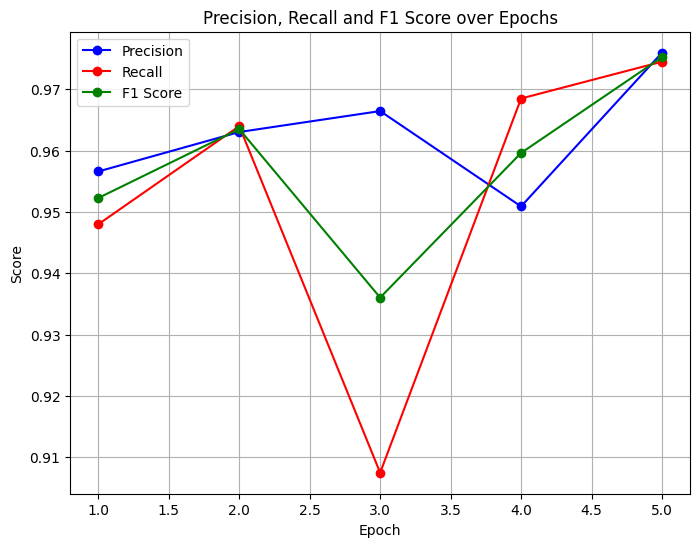

In [34]:

# Plot Precision, Recall, F1 Score over Epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), precisions, marker='o', color='b', label='Precision')
plt.plot(range(1, 6), recalls, marker='o', color='r', label='Recall')
plt.plot(range(1, 6), f1_scores, marker='o', color='g', label='F1 Score')
plt.title('Precision, Recall and F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


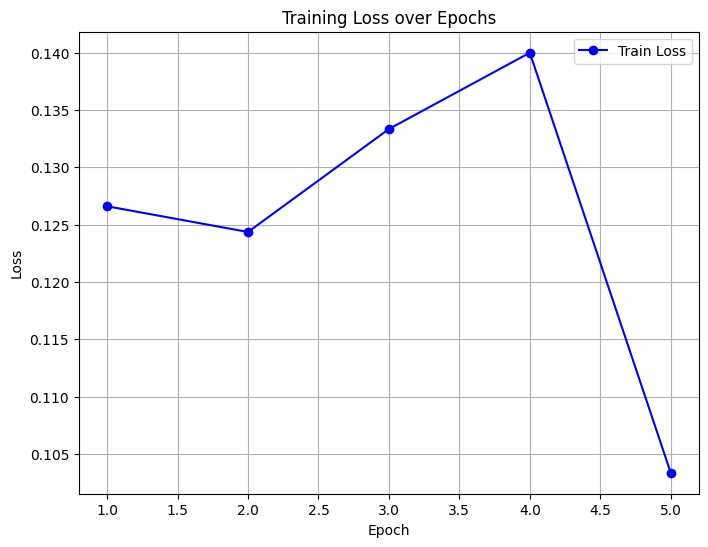

In [35]:

# Plot Training Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), train_losses, marker='o', color='b', label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
import torch

model_path = 'Windows_API_Sequences_model.pth' 
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to Windows_API_Sequences_model.pth


# 換您試試
我們設計了新資料集提供給同學訓練與測試，
請參考上方的程式碼，
讓模型能夠讀取新資料來訓練模型!

以下提供下載我們提供資料集連結的方法，以及一些必要的前處理

In [19]:
import gdown

In [31]:
!pip install gdown

import gdown

file_id = '10mcBZM8Aub5WiLZO92iuLfvWwjvn7gp_'
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, 'ais3.zip', quiet=False)


zsh:1: command not found: pip


Downloading...
From (original): https://drive.google.com/uc?id=10mcBZM8Aub5WiLZO92iuLfvWwjvn7gp_
From (redirected): https://drive.google.com/uc?id=10mcBZM8Aub5WiLZO92iuLfvWwjvn7gp_&confirm=t&uuid=fecbe574-1845-4d99-86e0-5ea48135f8de
To: /Users/shengshan/Desktop/code/NTNU-AIS-YARA-Course/Lab2/dataset.zip
100%|██████████| 195M/195M [00:42<00:00, 4.59MB/s] 


'dataset.zip'

In [32]:
!unzip ais3.zip

Archive:  dataset.zip
   creating: ais3/
   creating: ais3/mal/
   creating: ais3/mal/4d423b3ed84f438fb8d96ed825d93ff5/
  inflating: ais3/mal/4d423b3ed84f438fb8d96ed825d93ff5/summary_report.json  
 extracting: ais3/mal/4d423b3ed84f438fb8d96ed825d93ff5/winlogbeat.json  
  inflating: ais3/mal/4d423b3ed84f438fb8d96ed825d93ff5/dynamic_report.json  
  inflating: ais3/mal/4d423b3ed84f438fb8d96ed825d93ff5/features.json  
  inflating: ais3/mal/4d423b3ed84f438fb8d96ed825d93ff5/static_report.json  
 extracting: ais3/mal/4d423b3ed84f438fb8d96ed825d93ff5/etw_log.json  
   creating: ais3/mal/81190efd451140d899d1dfada6554b6b/
  inflating: ais3/mal/81190efd451140d899d1dfada6554b6b/summary_report.json  
  inflating: ais3/mal/81190efd451140d899d1dfada6554b6b/winlogbeat.json  
  inflating: ais3/mal/81190efd451140d899d1dfada6554b6b/dynamic_report.json  
  inflating: ais3/mal/81190efd451140d899d1dfada6554b6b/features.json  
  inflating: ais3/mal/81190efd451140d899d1dfada6554b6b/static_report.json  
 extra

In [22]:
import os

def count_subdirectories(root_dir, label):
    label_dir = os.path.join(root_dir, label)
    if not os.path.isdir(label_dir):
        return 0
    return sum([1 for name in os.listdir(label_dir) if os.path.isdir(os.path.join(label_dir, name))])


root_dir = 'ais3'
ben_count = count_subdirectories(root_dir, 'ben')
mal_count = count_subdirectories(root_dir, 'mal')

print(f"'ben' 資料夾中的子資料夾數量: {ben_count}")
print(f"'mal' 資料夾中的子資料夾數量: {mal_count}")

'ben' 資料夾中的子資料夾數量: 200
'mal' 資料夾中的子資料夾數量: 135


In [23]:
import os
import json
import numpy as np
from collections import defaultdict

def read_api_calls_from_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    api_calls = []
    for process in data['processes']:
        for call in process.get('calls', []):
            api = call.get('api')
            if api:
                api_calls.append(api)
    return api_calls

def collect_api_calls(root_dir):
    api_sequences = []
    labels = []
    for label, label_value in zip(['ben', 'mal'], [0, 1]):
        label_dir = os.path.join(root_dir, label)
        if not os.path.isdir(label_dir):
            continue
        for subdir in os.listdir(label_dir):
            subdir_path = os.path.join(label_dir, subdir)
            json_path = os.path.join(subdir_path, 'dynamic_report.json')
            if os.path.isfile(json_path):
                api_calls = read_api_calls_from_json(json_path)
                if api_calls:
                    api_sequences.append(api_calls)
                    labels.append(label_value)
    return api_sequences, labels

def build_vocabulary(api_sequences):
    vocabulary = defaultdict(lambda: len(vocabulary) + 1)
    for sequence in api_sequences:
        for api in sequence:
            _ = vocabulary[api]
    return dict(vocabulary)

def encode_sequences(api_sequences, vocabulary):
    encoded_sequences = []
    for sequence in api_sequences:
        encoded_sequence = [vocabulary[api] for api in sequence]
        encoded_sequences.append(encoded_sequence)
    return encoded_sequences

def pad_sequences(encoded_sequences, max_length):
    padded_sequences = np.zeros((len(encoded_sequences), max_length), dtype=int)
    for i, sequence in enumerate(encoded_sequences):
        length = min(len(sequence), max_length)
        padded_sequences[i, :length] = sequence[:length]
    return padded_sequences

root_dir = 'dataset'
api_sequences, labels = collect_api_calls(root_dir)

# 建立 API 調用的字典映射
vocabulary = build_vocabulary(api_sequences)

# 將 API 調用序列轉換為數字序列
encoded_sequences = encode_sequences(api_sequences, vocabulary)

max_length = 1000

# 將數字序列填充到相同的長度
padded_sequences = pad_sequences(encoded_sequences, max_length)

# 將標籤轉換為 NumPy 陣列
labels_array = np.array(labels).reshape(-1, 1)

print("Padded API sequences:")
print(padded_sequences[0])
print("Labels:")
print(labels_array[0])


Padded API sequences:
[ 1  2  1  2  2  3  3  3  4  2  5  2  6  2  4  6  2  2  2  2  6  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  7  8  8  9 10 11  9 12 13 14 15 13 14 15  4 16 17
 18 19 20 21 22 23 23 23 23 23 23 15 15 23  3 23 23 23 23  3  6  6 24  6
 25 26 26 12 23 23 19 19 15 15 15 15 15 27 15 15 24  8 15  8  8  8 28 15
 15  4 23 23 19 19  8  8  8  1  2  4 29 30  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  

In [24]:
from sklearn.model_selection import train_test_split

labels_array = np.array(labels).reshape(-1, 1)

# 切分數據集為訓練集和測試集，比例為8:2
train_x, test_x, train_y, test_y = train_test_split(padded_sequences, labels_array, test_size=0.2, random_state=42)


In [25]:
train_x

array([[20, 21, 22, ...,  8,  9,  8],
       [23,  1,  2, ...,  0,  0,  0],
       [31,  9, 16, ..., 35, 34, 15],
       ...,
       [23,  1,  2, ..., 15, 15, 15],
       [17, 21, 22, ...,  0,  0,  0],
       [23,  1,  2, ...,  0,  0,  0]])

In [26]:
train_y

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
    

In [ ]:
# 後面請輸出新的 F1-Score, Preicison, Recall 的圖 及 Training Loss 的圖